In [86]:
import datetime
from itertools import combinations
from typing import NamedTuple
from matplotlib import pyplot as plot
from git import Repo
import networkx as nx
from pprint import pprint


In [87]:
repo = Repo("../quizzology")

In [88]:
little_labels = dict(with_labels=True, font_size=7)
medium_labels = dict(with_labels=True, font_size=7)

In [89]:
print(list(combinations([1,2,3,4],2)))

[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


In [90]:
repo_graph = nx.Graph()
for commit in repo.iter_commits():
    for (left,right) in combinations(commit.stats.files,2):
        if (left,right) in repo_graph.edges:
            data = repo_graph.get_edge_data(left,right)
            data['count'] = data.get('count',1) + 1
        else:
            repo_graph.add_edge(left,right, count=1, timestamp=commit.committed_datetime)


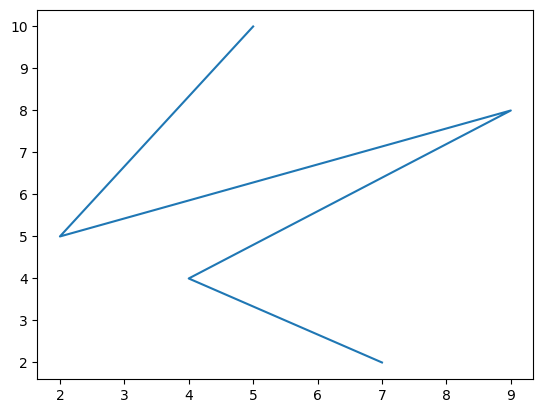

In [91]:
# Create a plot 

x = [5, 2, 9, 4, 7]
y = [10, 5, 8, 4, 2]
plot.plot(x, y)
plot.show()

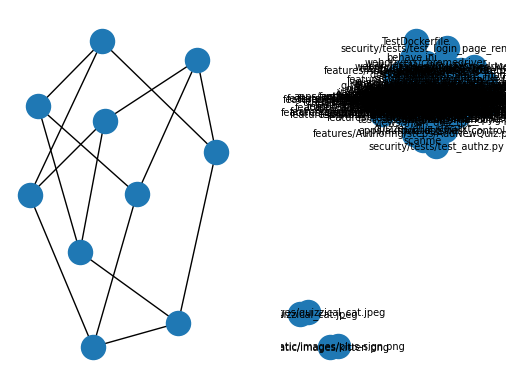

In [92]:
# Draw a network plot of some kind

graph = nx.petersen_graph() # well known sample data 
subax = plot.subplot(121)
nx.draw(graph)

repo_plot = plot.subplot(122)
nx.draw(repo_graph, **little_labels)



In [93]:
#help(nx.draw)


In [94]:

pprint(list(nx.connected_components(repo_graph)))


[{'.dockerignore',
  '.github/workflows/quizzology-ci.yml',
  '.gitignore',
  '.pylintrc',
  'Dockerfile',
  'README.md',
  'TestDockerfile',
  'apps/__init__.py',
  'apps/author.py',
  'apps/author/__init__.py',
  'apps/author/author.py',
  'apps/author/author_controller.py',
  'apps/author/tests/__init__.py',
  'apps/author/tests/test_authorcontroller.py',
  'apps/author/tests/test_controller.py',
  'apps/author/tests/test_quiz_authoring_form.py',
  'apps/author/tests/test_quiz_schema.py',
  'apps/author/views/quiz_author_home.tpl',
  'apps/author/views/quiz_authoring_form.tpl',
  'apps/authoring/__init__.py',
  'apps/authoring/author.py',
  'apps/authoring/views/quiz_authoring_form.tpl',
  'apps/study.py',
  'apps/study/__init__.py',
  'apps/study/session_store.py',
  'apps/study/session_store_mongodb.py',
  'apps/study/session_store_tinydb.py',
  'apps/study/study.py',
  'apps/study/studycontroller.py',
  'apps/study/tests/__init__.py',
  'apps/study/tests/test_quiz_question.py',
 

In [95]:
# Perhaps we should trim the data set so that we don't plot every single 
# edge and node in one ugly graph.

busiest_graph = nx.Graph()
busiest_graph.add_edges_from(edge 
                             for edge in repo_graph.edges 
                             if repo_graph.get_edge_data(*edge).get('count',0) > 10)


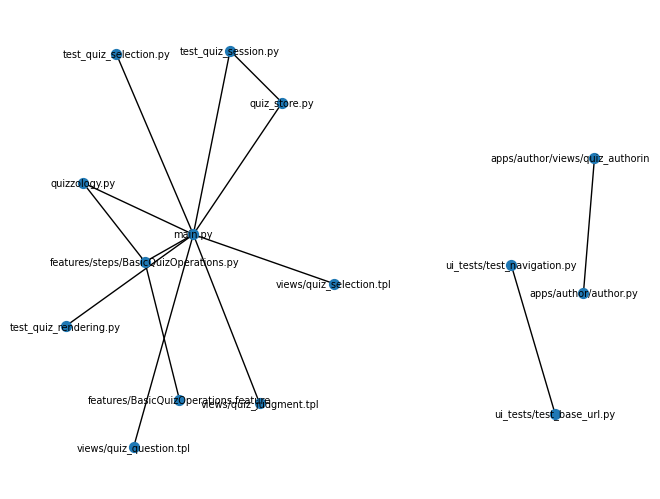

In [96]:
from networkx import spring_layout 
layout= spring_layout(busiest_graph, k=0.8, iterations=50)
nx.draw(busiest_graph, layout, **little_labels, node_size=50)


In [97]:
# Not my best choice here.
#nx.draw_spectral(busiest_graph, **little_labels) 
# Completely unusable


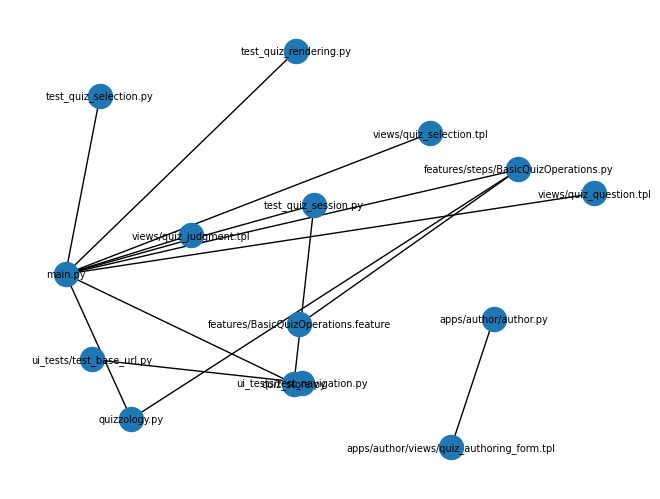

In [98]:
nx.draw_random(busiest_graph, **little_labels)


# Concept

If we combine *most committed*, and *most connected*, and some *complexity* measure, then we should end up with a basis for a ranked "refactoring candidate" list. 

## Hypothesis: TARGET SELECTION
Imagine pointing a tool at a codebase, and it tells you where to concentrate your efforts on code renewal, and maybe you re-run it monthly or weekly? Would this make a significant difference in fluidity, fluency, speed, and quality? 

## Notes

- This needs to be time-limited or it will be based on all-time, not recent activity.
- When you first rework a file, it will still show up in the list
- Maybe when we refactor a file, it can drop it out of the candidate list. If it is still aproblem, it will reappear later, when that refactoring commit "ages out."
- if this only works with "conventional commits," that's probably okay. We could also support Belshee's cryptic commit trickery.


In [99]:
print(list(nx.connected_components(repo_graph))[-1])

{'static/quizzical_cat.jpeg', 'static/images/quizzical_cat.jpeg'}


Interesting ideas
* Average commit size
* Tests included in commits?
* Connected groups
* Most edited files
* Commit frequency
* Defects vs Features vs Refactors vs Other (conventional commits?)
* Ticket numbers and clustering of same

In [100]:
# Average commit size
repo = Repo('../quizzology')
commits = [(commit.author.name, commit.authored_datetime, len(commit.stats.files))
           for commit 
           in repo.iter_commits()
          ]
pprint(commits[:3])

[('Tim Ottinger',
  datetime.datetime(2022, 10, 18, 14, 19, 4, tzinfo=<git.objects.util.tzoffset object at 0x2b50df1d0>),
  1),
 ('Perry Reid',
  datetime.datetime(2022, 9, 14, 8, 58, 33, tzinfo=<git.objects.util.tzoffset object at 0x2b5139fd0>),
  2),
 ('Perry Reid',
  datetime.datetime(2022, 9, 13, 8, 52, 54, tzinfo=<git.objects.util.tzoffset object at 0x2b50b4790>),
  3)]


In [101]:
# How to break into separate components? 

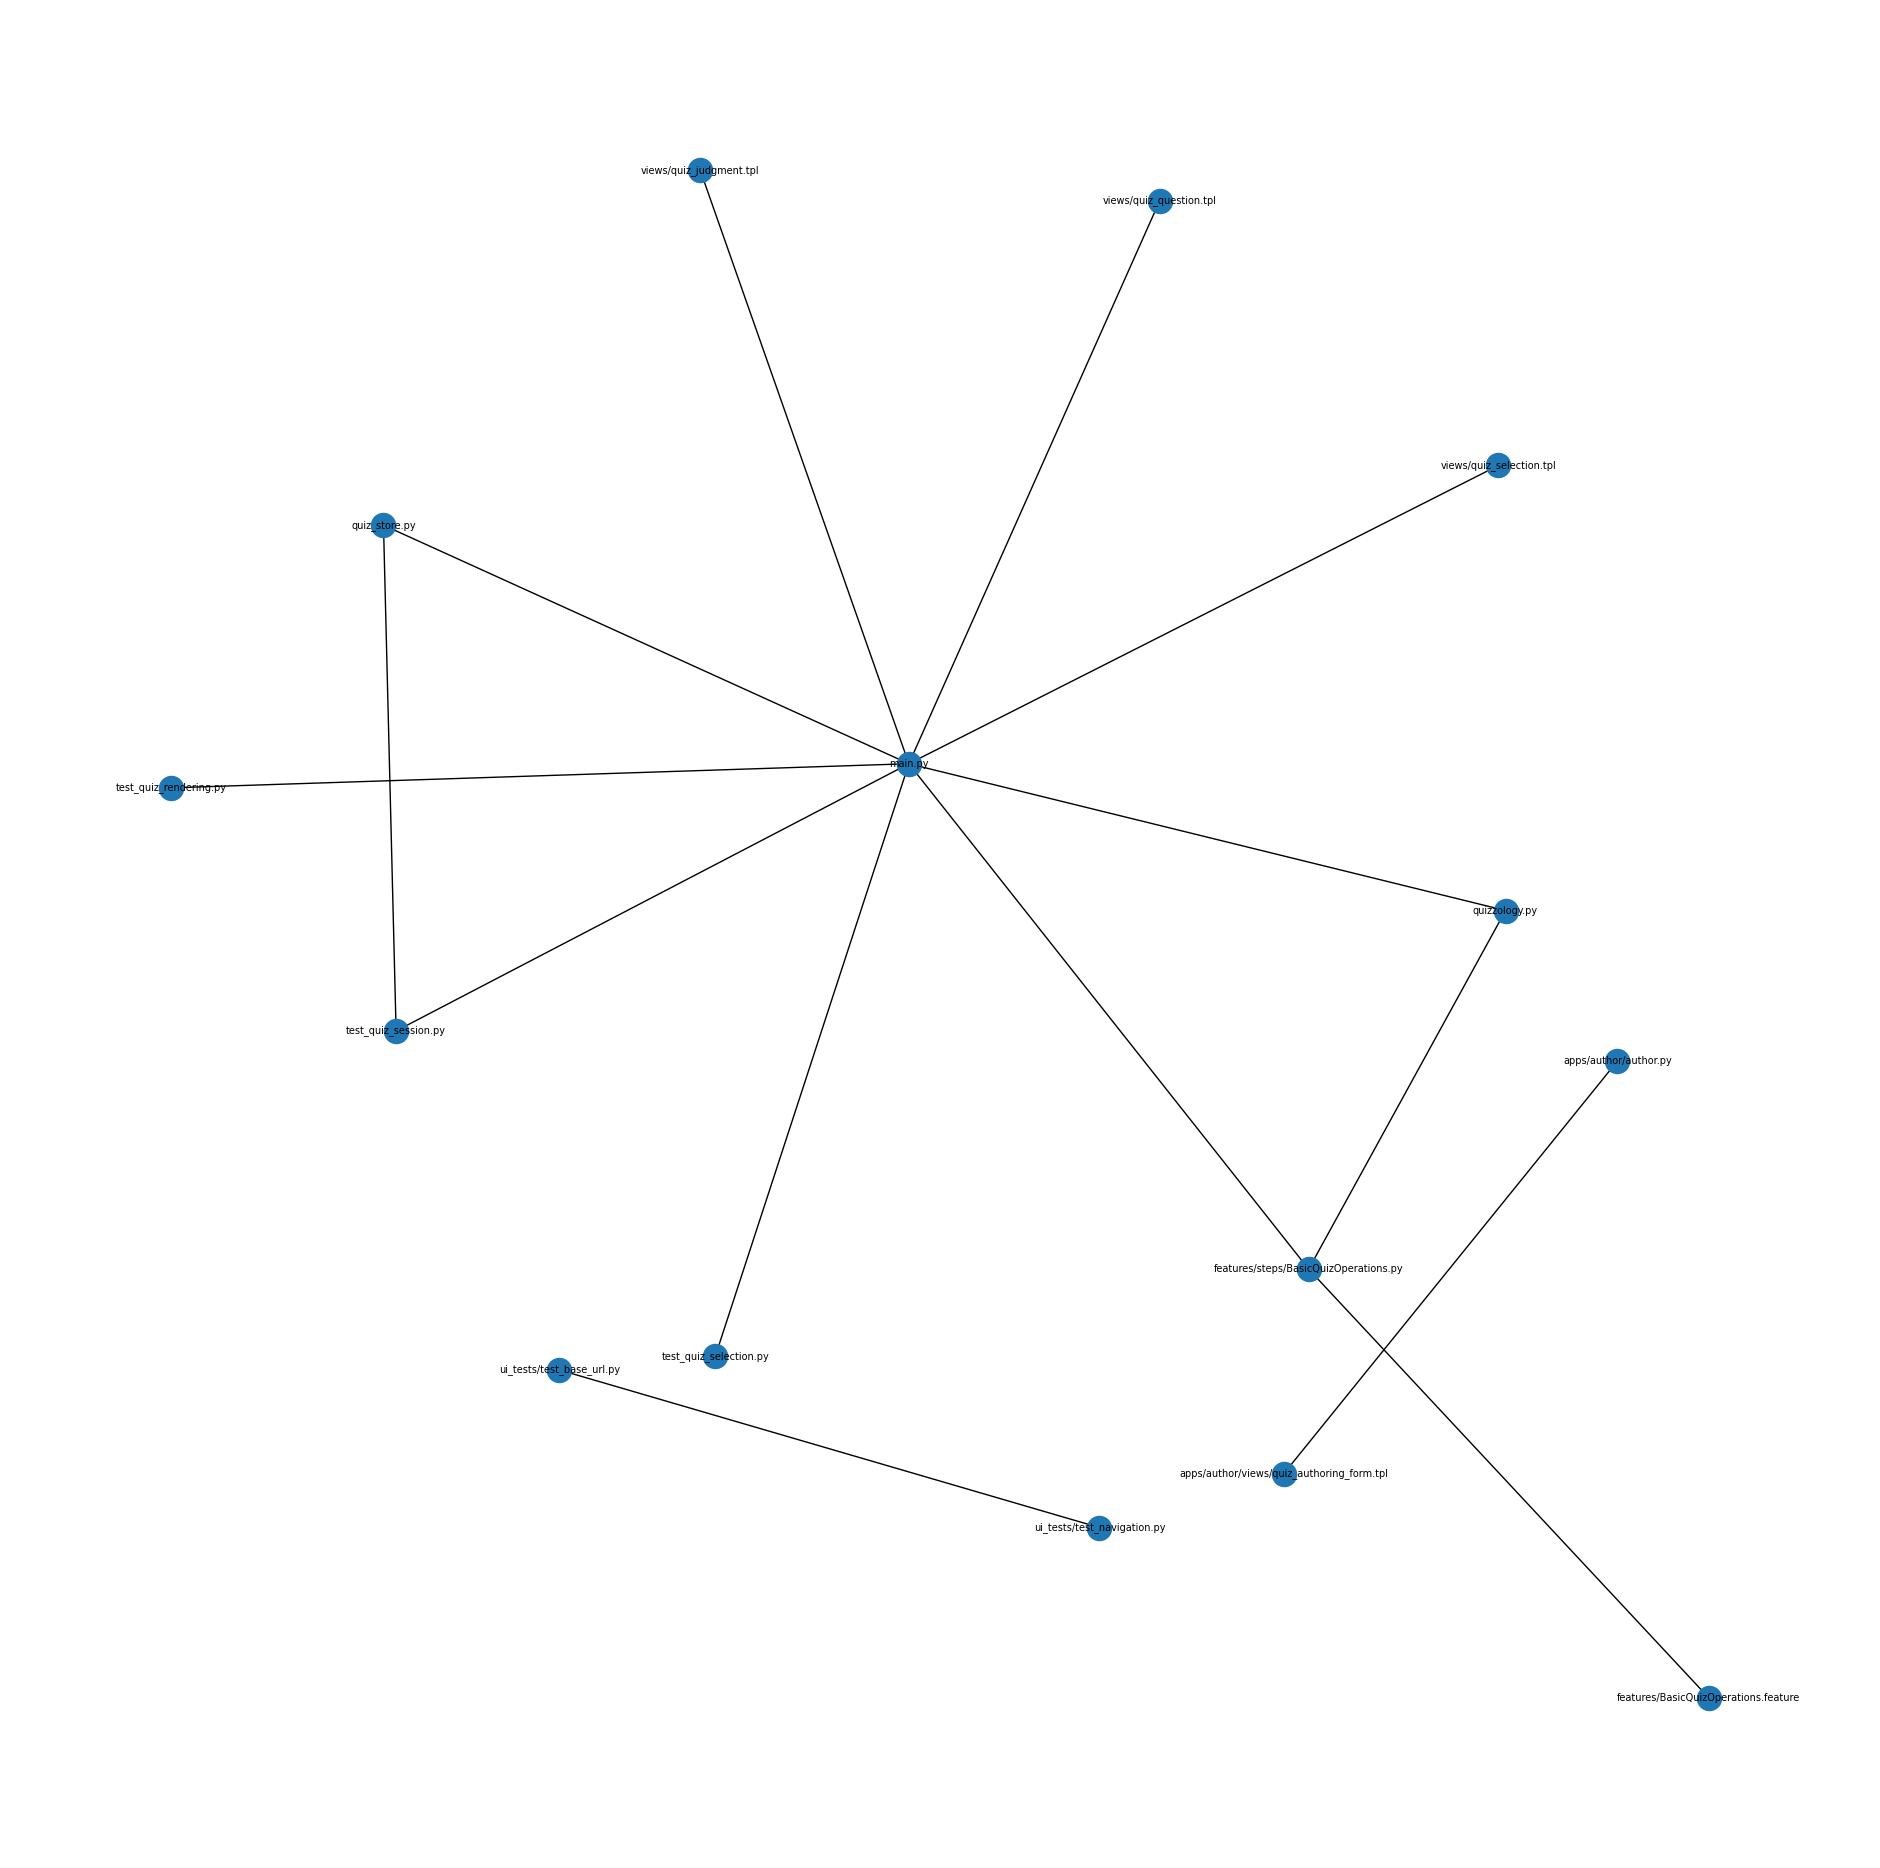

In [102]:
fig, ax = plot.subplots(figsize=(24,24))
nx.draw_kamada_kawai(busiest_graph, **medium_labels)

In [103]:
#What if we remove the most heavily connected items instead of the least-heavily?


In [104]:
from statistics import mean, stdev, variance, multimode
def print_stats(filecounts):
    print(f'  Largest commit is {max(counters)} files')
    print(f'  Average commit is {mean(counters)} files')
    print(f'  Standard Deviation is {stdev(counters)}')
    print(f'  Variance is {variance(counters)}')
    print(f'  Multimode is {multimode(counters)}')

In [105]:
print("FULL repository Data Set")
print_stats([ x for (_,_,x) in commits ])

FULL repository Data Set
  Largest commit is 30 files
  Average commit is 2.3156532988357053 files
  Standard Deviation is 2.222407261300911
  Variance is 4.9390940350830155
  Multimode is [1]


In [106]:
# Maybe a digraph is wise? 
repo = Repo("../quizzology")
repo_multigraph = nx.MultiGraph()
for commit in repo.iter_commits():
    for (left,right) in combinations(commit.stats.files,2):
        repo_multigraph.add_edge(left,right)

# Activity Graph Concept
A graph of the number of commits per day might be useful - a stacked bar graph if you can tell what kinds of commits.
I imagine coloring the stack by 'conventional commit' topics: fixes on bottom, then feature, then whatever else.
'Commit Cadence'

Can we discern the kinds of commits we're looking at via ticket names, conventional commits, or belshee commits?

Can we eliminate trivial commits (less than one line of change, less than 10 characters, etc)?

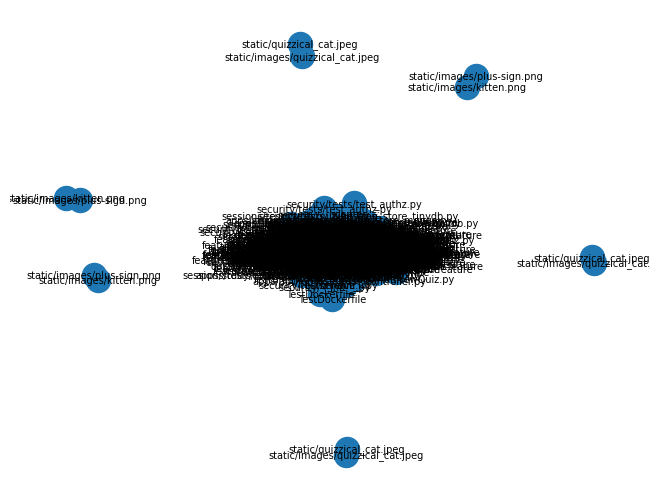

In [107]:
# This is probably the wrong visualization. 
for topic in nx.connected_components(repo_multigraph):
    nx.draw(repo_multigraph, **little_labels )
    # Kittens appear more than once, as do quizzical cats. I think this provides too much info.

In [108]:
from datetime import datetime, timedelta

now = datetime.today().astimezone()
days = 400
print(f'Since {(now - timedelta(days=days)).isoformat()} ')
dataset = [count for (author,timestamp,count)
           in commits
           if (now - timestamp).days <= days  ]


print(f'commits: {len(dataset)}')
print_stats(dataset)

Since 2022-03-03T08:58:59.055570-05:00 
commits: 208
  Largest commit is 30 files
  Average commit is 2.3156532988357053 files
  Standard Deviation is 2.222407261300911
  Variance is 4.9390940350830155
  Multimode is [1]
